# Characterising KIC 11615890 with lightkurve

The star HD 221416 was recently found to be harbouring a hot Saturn-type planet, the first transiting planet identified by TESS for which asteroseismology of the host star is possible.

In this notebook we will go through step-by-step from TESS data to a rudimentary analysis of the asteroseismic mass, radius, and surface gravity of the star.

In [57]:
import lightkurve as lk
import numpy as np

datalist = lk.search_lightcurvefile('KIC11615890', quarter=5)

In [58]:
lc = datalist.download().PDCSAP_FLUX

In [59]:
lc = lc.flatten().remove_outliers().remove_nans()

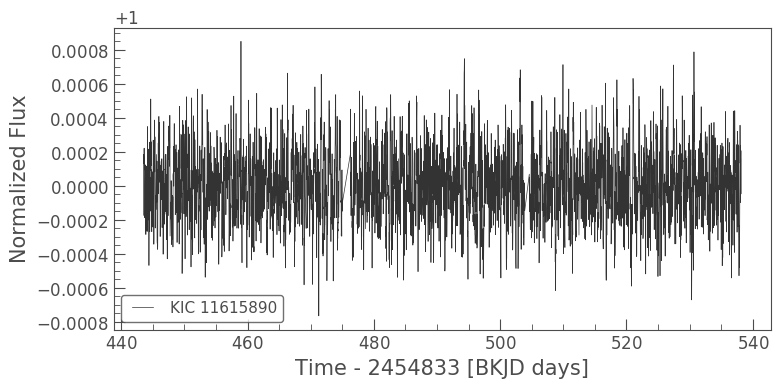

In [60]:
lc.plot()

Neat, we've got some data, and the transits are pretty clear! Now let's try and do some asteroseismology with it.

In [61]:
pg = lc.to_periodogram(method='lombscargle', normalization='psd')

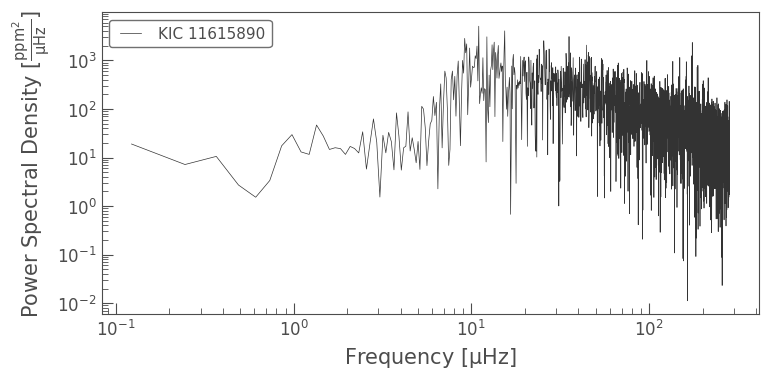

In [62]:
pg.plot(scale='log')

It looks like theres a bit of power excess at around ~400 $\mu Hz$. Lets zone in on that area...

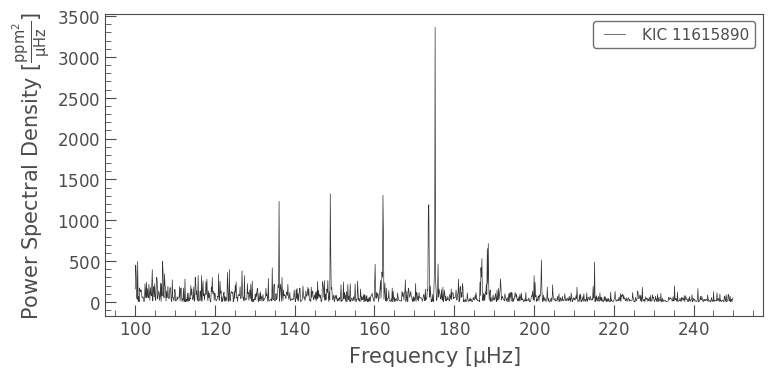

In [68]:
pg = lc.to_periodogram(method='lombscargle', normalization='psd',
                      minimum_frequency=100, maximum_frequency=250)
pg.plot()

We could make a very rudimentary guess at $\nu_{\rm max}$ with that highest peak there. The `periodogram` object stores this info, lets have a look!

In [69]:
pg.show_properties()

lightkurve.Periodogram properties:
      Attribute         Description     Units   
---------------------- -------------- ----------
              targetid       11615890           
          default_view      frequency           
                 label   KIC 11615890           
frequency_at_max_power       175.2029        uHz
             max_power      3362.3853 ppm2 / uHz
               nyquist       283.2029        uHz
   period_at_max_power         0.0057    1 / uHz
             frequency  array (1227,)        uHz
                period  array (1227,)    1 / uHz
                 power  array (1227,) ppm2 / uHz
                  meta <class 'dict'>           


The peak is located at $420 \mu Hz$. Lets see if we can verify that at all.

## Using lightkurve's asteroseismology tools

Before we can use the seismology tools, we want to flatten out the background so we get a Signal-to-noise spectrum.

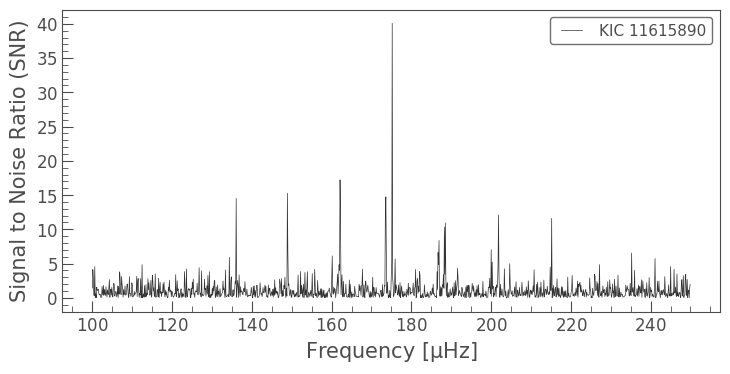

In [70]:
snr = pg.flatten()
snr.plot()

Alright, now let's get to business and try to estimate $\nu_{\rm max}$. The built-in method uses an Autocorrelation Function (see the docstrings for more details) to find where the power excess is highest in a shape approximately close to what we would expect for a solar-like oscillator's modes.

In [71]:
numax = snr.estimate_numax()
numax

ValueError: negative dimensions are not allowed

Looks like something's gone wrong here. Let's inspect the $\nu_{\rm max}$ estimation process.

In [72]:
numax, ax = snr.plot_numax_diagnostics()

ValueError: negative dimensions are not allowed

Alright, I'm not sure whats going on here and I'm going to have to fix it. Good thing I'm testing stuff.

I'm just going to treat the big peak as numax for now.

In [25]:
numax = snr.frequency_at_max_power
numax

<Quantity 420.13909321 uHz>

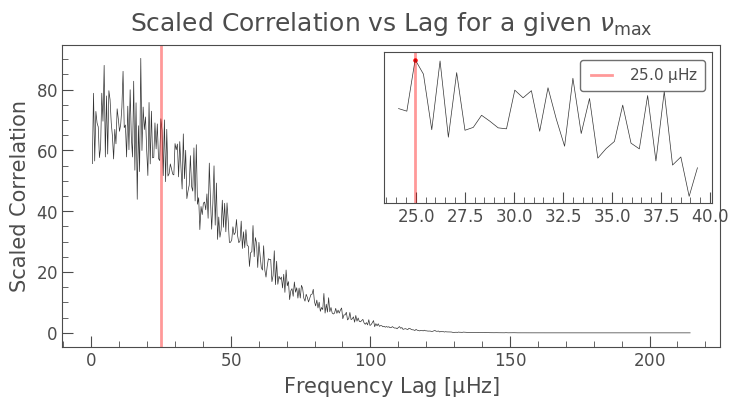

In [30]:
dnu, ax = snr.plot_dnu_diagnostics(430)